In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!tar xfz "/content/drive/MyDrive/words.tgz"

In [3]:
!cp /content/drive/MyDrive/parser.txt /content/

In [4]:
f=open("/content/parser.txt","r")
d=f.read()
f.close()
data=d.split("\n")

In [5]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img


In [6]:
import string
def encode(txt,vocab):
  m=[]
  for index,character in enumerate(txt):
    m.append(vocab.index(character))
  return m

word A
A [26]


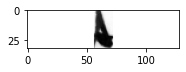

word MOVE
MOVE [38, 40, 47, 30]


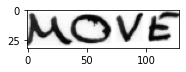

word to
to [19, 14]


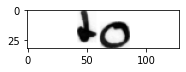

word stop
stop [18, 19, 14, 15]


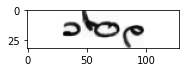

word Mr.
Mr. [38, 17, 75]


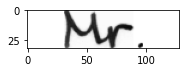

word Gaitskell
Gaitskell [32, 0, 8, 19, 18, 10, 4, 11, 11]


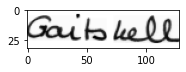

word from
from [5, 17, 14, 12]


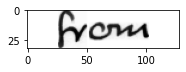

word nominating
nominating [13, 14, 12, 8, 13, 0, 19, 8, 13, 6]


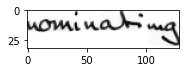

word any
any [0, 13, 24]


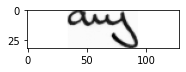

word more
more [12, 14, 17, 4]


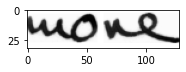

word Labour
Labour [37, 0, 1, 14, 20, 17]


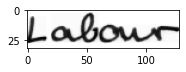

word life
life [11, 8, 5, 4]


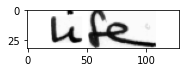

word Peers
Peers [41, 4, 4, 17, 18]


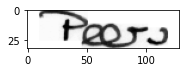

word is
is [8, 18]


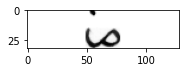

word to
to [19, 14]


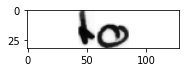

word be
be [1, 4]


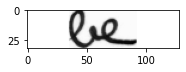

word made
made [12, 0, 3, 4]


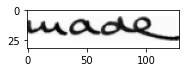

word at
at [0, 19]


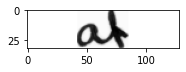

word a
a [0]


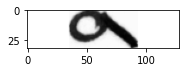

word meeting
meeting [12, 4, 4, 19, 8, 13, 6]


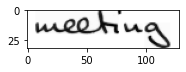

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
num=0
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

max_len = 0

for i in range(len(data[:20])):
  num+=1
  if num<10000:
    ds=data[i].split(" ")
    status=ds[1]
    word=ds[-1]
    if status=="ok":
        fns=ds[0].split("-")
        path="/content/{}/{}-{}/{}.png".format(fns[0],fns[0],fns[1],ds[0])
        
        img=preprocess(path,128,32)
        vocab=string.ascii_letters + string.digits + string.punctuation
        label=encode(word,vocab)
        print("word",word)
        
        if i % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        if len(word) > max_len:
            max_len = len(word)
        if i >= 10000:
            break
        # plt.subplot(121)
        # print(word,label)
        # plt.imshow(img, cmap='gray')
        # plt.show()

In [8]:
import tensorflow as tf
from keras import backend as K
train_labels=tf.keras.preprocessing.sequence.pad_sequences(train_labels,16,padding="post",value=len(vocab))
valid_labels=tf.keras.preprocessing.sequence.pad_sequences(valid_labels,16,padding="post",value=len(vocab))

In [9]:
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,BatchNormalization,Lambda,Bidirectional,LSTM,Dense
from tensorflow.keras import Model
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(vocab)+1, activation = 'softmax')(blstm_2)
 
act_model = Model(inputs, outputs)

In [10]:
labels = Input(name='the_labels', shape=[16], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [11]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [13]:
training_img = np.asarray(train_images)
training_img = np.expand_dims(training_img,axis=-1)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)
train_labels=np.asarray(train_labels)

valid_img = np.asarray(valid_images)
valid_img = np.expand_dims(valid_img,axis=-1)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)
valid_labels=np.asarray(valid_labels)

model.fit(x=[training_img, train_labels, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=256, epochs = 10, validation_data = ([valid_img, valid_labels, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)


Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 117.8734 - val_loss: 116.9451

Epoch 00001: val_loss improved from inf to 116.94508, saving model to best_model.hdf5
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 59.8643 - val_loss: 76.1061

Epoch 00002: val_loss improved from 116.94508 to 76.10611, saving model to best_model.hdf5
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 26.6412 - val_loss: 26.4631

Epoch 00003: val_loss improved from 76.10611 to 26.46307, saving model to best_model.hdf5
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 19.7135 - val_loss: 18.3771

Epoch 00004: val_loss improved from 26.46307 to 18.37712, saving model to best_model.hdf5
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 20.0915 - val_loss: 19.0639

Epoch 00005: val_loss did not improve from 18.37712
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 20.7308 - val_loss: 19.7561


In [17]:
valid_img =valid_img.reshape(2,32,128)

In [21]:
act_model.load_weights('/content/best_model.hdf5')
 
# predict outputs on validation images
prediction = act_model.predict(valid_img)
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
i = 0
for x in out:
    print(valid_original_text[i])
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

A


Labour


